In [1]:
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, AutoModel
from adapters import AutoAdapterModel, AdapterConfig
from torch.optim import AdamW
import pandas as pd
from torch.utils.data import random_split, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
import torch.nn as nn
from sklearn.utils import compute_class_weight
from peft import LoraConfig, get_peft_model

import os
import tqdm as notebook_tqdm

import numpy as np
import time
import datetime
import random

import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.manual_seed(42)

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [3]:
def encode_label(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    print(f"Encoder has the following classes: {encoder.classes_}")
    print(f"The new data type for y is {type(y)}")

    return y

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def get_TP_FP_FN(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    TP = np.sum((pred_flat == 1) & (labels_flat == 1))
    FP = np.sum((pred_flat == 1) & (labels_flat == 0))
    FN = np.sum((pred_flat == 0) & (labels_flat == 1))

    return {'TP': TP,
            'FP': FP,
            'FN': FN}


def precision(TP, FP):
    if TP + FP == 0:
        return 0
    else:
        return TP / (TP + FP)


def recall(TP, FN):
    if TP + FN == 0:
        return 0
    else:
        return TP / (TP + FN)


def f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    else:
        return 2 * precision * recall / (precision + recall)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
model_name = "google/muril-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           num_labels=2, 
                                                           output_hidden_states=False)


hinglish_hate_1 = LoraConfig(task_type="SEQ_CLS",
                         inference_mode=False,
                         lora_alpha=16,
                         lora_dropout=0.1,
                         r=32)

model = get_peft_model(model, hinglish_hate_1)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(197285, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (defaul

In [7]:
df = pd.read_csv("data/hate-dataset.csv")
df = df.drop(['text'], axis=1)
df.head()

,label,data
0,non-hate,nice buro yes i am हुसैन खान is me happy owesi...
1,hate,भवन k लोडे कटुए काट k फेंक देंगे बहनचोद तुझे सुअर
2,hate,ye india के सारे मुसलमान बाबर or अकबर की नागरा...
3,hate,भाई इनकी मां चोद do मील को आहा b मिले हिन्दू म...
4,hate,गलती हो गई बाबा साहब अंबेडकर se तुन जैसे lunf ...


In [8]:
X = df.data.values
y = df.label.values

y = encode_label(y)

class_weight = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight = torch.tensor(class_weight, dtype=torch.float)
class_weight = class_weight.to(device)

input_ids = []
attention_masks = []

# convert the sentences into tokens for MuRIL
# pre-processing, append input_ids and
# attention_masks into a list
for sentence in X:
    encoded_dict = tokenizer.encode_plus(
                                        sentence,
                                        add_special_tokens=True,
                                        max_length=128,
                                        padding='max_length',
                                        truncation=True,
                                        return_attention_mask=True,
                                        return_tensors='pt'
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


# convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

# print a visualisation
print('Original: ', X[0])
print('Token IDs:', input_ids[0])
print('Label:', labels[0])

Encoder has the following classes: ['hate' 'non-hate']
The new data type for y is <class 'numpy.ndarray'>


Original:  nice buro yes i am हुसैन खान is me happy owesi brothers and cold and my friend is all is well with your video
Token IDs: tensor([   104,  19634,    173,  55696,  29768,    180,   3516,  26436,   3907,
          1121,   1868,   9971,    186, 107972,   1206,  19412,   1111,  15756,
          1111,   1725,   8462,   1121,   1375,   1121,   1999,   1147,   1427,
          3080,    105,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,     

In [12]:
batch_size = 32

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"{train_size} training samples")
print(f"{val_size} validation samples")

train_dataloader = DataLoader(
                train_dataset,
                sampler = RandomSampler(train_dataset),
                batch_size = batch_size
)

validation_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset),
                batch_size = batch_size
)

22672 training samples
5668 validation samples


In [10]:
epochs = 10

optimizer = AdamW(model.parameters(),
                lr = 2e-5,
                eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [13]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()


for epoch_i in range(0, epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('\tBatch {:>5,}  of  {:>5,}.\tElapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()


        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        #loss = outputs.loss
        criterion = nn.CrossEntropyLoss(weight=class_weight, reduction='mean')
        
        loss = criterion(outputs.logits, b_labels)
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()


    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("\nAverage training loss: {0:.2f}".format(avg_train_loss))
    print("\nTraining epoch took: {:}".format(training_time))


    print("\nRunning validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    total_prec = 0
    total_rec = 0

    prec = 0
    rec = 0
    f1_val = 0

    TP = 0
    FP = 0
    FN = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)

            criterion = nn.CrossEntropyLoss(weight=class_weight, reduction='mean')

            loss = criterion(outputs.logits, b_labels)
            logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

        counts = get_TP_FP_FN(logits, label_ids)

        TP = counts['TP']
        FP = counts['FP']
        FN = counts['FN']

        total_prec += precision(TP, FP)
        total_rec += recall(TP, FN)


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("\tAccuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("\nValidation Loss: {0:.2f}".format(avg_val_loss))
    print("\nValidation took: {:}".format(validation_time))


    prec = total_prec / len(validation_dataloader)
    rec = total_rec / len(validation_dataloader)
    f1_val = f1_score(prec, rec)

    print("\nPrecision: {0:.2f}".format(prec))
    print("Recall: {0:.2f}".format(rec))
    print("F1 Score: {0:.2f}".format(f1_val))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1_val,
        }
    )

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...


	Batch    40  of    709.	Elapsed: 0:00:08.
	Batch    80  of    709.	Elapsed: 0:00:16.
	Batch   120  of    709.	Elapsed: 0:00:24.
	Batch   160  of    709.	Elapsed: 0:00:32.
	Batch   200  of    709.	Elapsed: 0:00:40.
	Batch   240  of    709.	Elapsed: 0:00:48.
	Batch   280  of    709.	Elapsed: 0:00:56.
	Batch   320  of    709.	Elapsed: 0:01:04.
	Batch   360  of    709.	Elapsed: 0:01:13.
	Batch   400  of    709.	Elapsed: 0:01:21.
	Batch   440  of    709.	Elapsed: 0:01:29.
	Batch   480  of    709.	Elapsed: 0:01:37.
	Batch   520  of    709.	Elapsed: 0:01:45.
	Batch   560  of    709.	Elapsed: 0:01:54.
	Batch   600  of    709.	Elapsed: 0:02:02.
	Batch   640  of    709.	Elapsed: 0:02:10.
	Batch   680  of    709.	Elapsed: 0:02:18.

Average training loss: 0.69

Training epoch took: 0:02:24

Running validation...
	Accuracy: 0.61

Validation Loss: 0.68

Validation took: 0:00:19

Precision: 0.74
Recall: 0.55
F1 Score: 0.63

======== Epoch 2 / 10 ========
Training...
	Batch    40  of    709.	Elapsed:

In [20]:
pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_csv("outputs/pure_adapter_stats.csv")

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time,Precision,Recall,F1 Score
epoch,,,,,,,,
1,0.69,0.68,0.61,0:02:24,0:00:19,0.74,0.55,0.63
2,0.68,0.67,0.64,0:02:26,0:00:19,0.75,0.63,0.68
3,0.67,0.66,0.66,0:02:26,0:00:20,0.74,0.70,0.72
4,0.66,0.65,0.66,0:02:26,0:00:20,0.76,0.66,0.70
5,0.65,0.65,0.67,0:02:27,0:00:19,0.74,0.72,0.73
6,0.64,0.64,0.67,0:02:25,0:00:19,0.75,0.69,0.72
7,0.64,0.63,0.67,0:02:27,0:00:20,0.77,0.66,0.71
8,0.63,0.63,0.69,0:02:27,0:00:19,0.74,0.77,0.75
9,0.63,0.62,0.69,0:02:26,0:00:19,0.75,0.74,0.75


In [15]:
path = '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf'
#path = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
font_manager.fontManager.addfont(path)

prop = font_manager.FontProperties(fname=path)
sns.set_theme(context='notebook', style='darkgrid', palette='crest', font=prop.get_name())

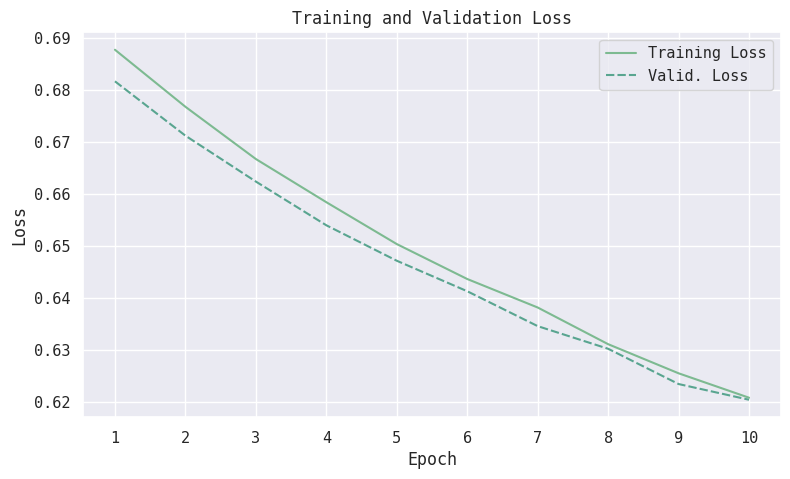

In [17]:
plt.figure(figsize=(9, 5))

sns.lineplot(data=df_stats[['Training Loss', 'Valid. Loss']]).set(title='Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#plt.savefig('outputs/pure_adapter_loss.png')
plt.show()

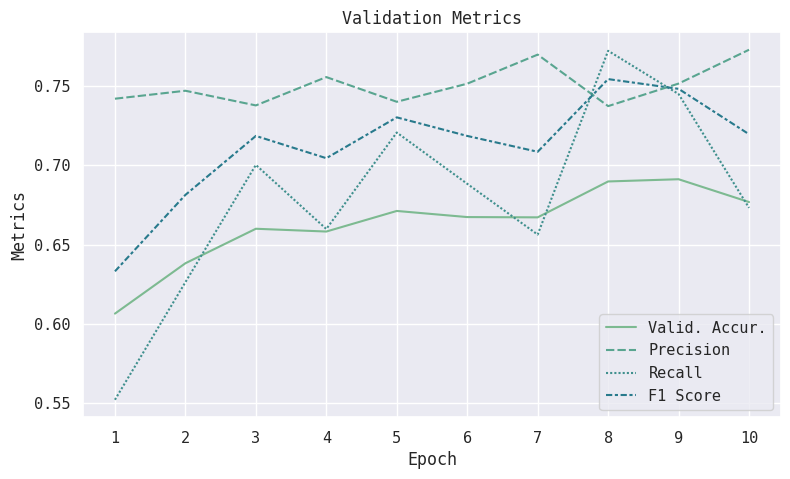

In [19]:
plt.figure(figsize=(9, 5))

sns.lineplot(data=df_stats[['Valid. Accur.', 'Precision', 'Recall', 'F1 Score']]).set(title='Validation Metrics')
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#plt.savefig('outputs/pure_adapter_metrics.png')
plt.show()